In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


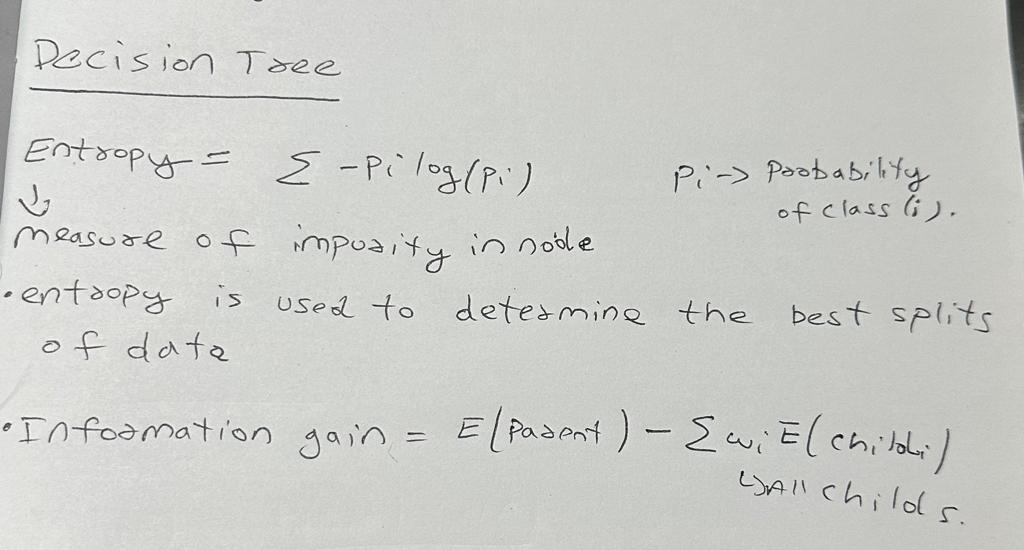

1) From Scratch

In [16]:
import numpy as np
import pandas as pd

# Load Iris dataset
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("/content/drive/MyDrive/machine_learning/datasets/Iris.csv", skiprows=1, header=None, names=col_names)

# Define Node class for decision tree nodes
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' Constructor for the Node class '''
        # For decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        # For leaf node
        self.value = value

# Define DecisionTreeClassifier class
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' Constructor for the DecisionTreeClassifier class '''
        # Initialize the root of the tree
        self.root = None
        # Stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        ''' Recursive function to build the tree '''
        X, Y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)

        # Split until stopping conditions are met
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            # Find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)

            # Check if information gain is positive
            if best_split["info_gain"] > 0:
                # Recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                # Recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)

                # Return decision node
                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["info_gain"])

        # Compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # Return leaf node
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        ''' Function to find the best split '''
        # Dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")

        # Loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            # Loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # Get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)

                # Check if children are not null
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]

                    # Compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")

                    # Update the best split if needed
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        # Return best split
        return best_split

    def split(self, dataset, feature_index, threshold):
        ''' Function to split the data '''
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' Function to compute information gain '''
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)

        if mode == "gini":
            gain = self.gini_index(parent) - (weight_l * self.gini_index(l_child) + weight_r * self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))

        return gain

    def entropy(self, y):
        ''' Function to compute entropy '''
        class_labels = np.unique(y)
        entropy = 0

        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)

        return entropy

    def gini_index(self, y):
        ''' Function to compute Gini index '''
        class_labels = np.unique(y)
        gini = 0

        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2

        return 1 - gini

    def calculate_leaf_value(self, Y):
        ''' Function to compute leaf node '''
        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):
        ''' Function to print the tree '''
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        ''' Function to train the tree '''
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        ''' Function to predict new dataset '''
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions

    def make_prediction(self, x, tree):
        ''' Function to predict a single data point '''
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]

        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

# Split data into features (X) and target variable (Y)
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1, 1)

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

# Create and train the Decision Tree Classifier
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = classifier.predict(X_test)

# Print true values, predicted values, and accuracy of the model
print("True Values:", Y_test.flatten())
print("Predicted Values:", np.array(Y_pred))
print("Accuracy:", accuracy_score(Y_test, Y_pred))


True Values: ['Iris-virginica' 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor'
 'Iris-virginica' 'Iris-virginica' 'Iris-virginica' 'Iris-setosa'
 'Iris-setosa' 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica'
 'Iris-setosa' 'Iris-versicolor' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-setosa' 'Iris-versicolor']
Predicted Values: ['Iris-virginica' 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor'
 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-setosa'
 'Iris-setosa' 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica'
 'Iris-setosa' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolo

2) Using SCIKIT

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load Iris dataset
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("/content/drive/MyDrive/machine_learning/datasets/Iris.csv", skiprows=1, header=None, names=col_names)

# Split data into features (X) and target variable (Y)
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

# Create and train the Decision Tree Classifier from scikit-learn
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = classifier.predict(X_test)

# Print true values, predicted values, and accuracy of the model
print("True Values:", Y_test.values)
print("Predicted Values:", Y_pred)
print("Accuracy:", accuracy_score(Y_test, Y_pred))


True Values: ['Iris-virginica' 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor'
 'Iris-virginica' 'Iris-virginica' 'Iris-virginica' 'Iris-setosa'
 'Iris-setosa' 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica'
 'Iris-setosa' 'Iris-versicolor' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-setosa' 'Iris-versicolor']
Predicted Values: ['Iris-versicolor' 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-virginica'
 'Iris-virginica' 'Iris-virginica' 'Iris-virginica' 'Iris-setosa'
 'Iris-setosa' 'Iris-versicolor' 'Iris-setosa' 'Iris-versicolor'
 'Iris-setosa' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor